https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data

https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product/data

Metal casting defect identification

Objective : Build a Deep learning model for quality inspection Defect / Non Defect
=> Classification model 

Product : Pump impleller 
Dataset count : 7348 , 2 datasets available with augmentation (300*300 gray scale) and without augmentation (512x512 grayscale => 519 ok and 781 not ok implellers)

train:- def_front have 3758 and ok_front have 2875 images

test:- def_front have:- def_front have 453 and ok_front have 262 images

=> 3758+2875+453+262 = 7348 

Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

Random seeding : These set a fixed seed value for random number generation. This ensures that the results are reproducible every time you run the script.
https://medium.com/towards-data-science/how-to-use-random-seeds-effectively-54a4cd855a79

https://www.geeksforgeeks.org/random-seed-in-python/

Useful when train,test and validtion splits to ensure same way of division of data

Model training of non deterministic outputs & benchmarking performance

In [2]:
np.random.seed(42)  # Ensures NumPy operations are reproducible
tf.random.set_seed(42)  # Ensures TensorFlow operations are reproducible
#any no. can be set instead of 42 ....its the probability of randomness of number

In [3]:
import random
random.seed(42)
# Set the seed
print(random.random())

0.6394267984578837


File paths : Here the defect and non defect files are segregted in test and train folders respectively

In [4]:
train_dir = 'C:/Explore/ML_AI/Projects/DL_projects/Metal_defect_classification/Dataset_disc_defects/casting_data/train'
test_dir = 'C:/Explore/ML_AI/Projects/DL_projects/Metal_defect_classification/Dataset_disc_defects/casting_data/test'

Data augmentation : Diversifying our datastet for model generalisation. The images may be of different size, shape , colour

We use keras image data generator here to do image augmentation. NVIDIA GTX is used in background in my case in terms of hardware

Keras image data generator tkes the batch of images and then does a series of random tansformation (resize,,rotation,shearing etc) and is used in traininginstead of original data (Note : class labels are changed, and some techniques re only pplied on train and not on test as we want more variability in training data not the test)

Methods / types of data augmentation
1) Geometric transformations - Translation, rotation, shearing, scale changes, flips / mirroring etc 
Can be useful hen we have limited dataset => expand the variability and data counts for training
But here behaviour variability is not captured for generalisation of the model = > behviour cloning as it may pass same type of data transfomrtion in the batch which will reduce generlisation
2) Behvaiour cloning => inplace / on the fly augmentation  --- keras image data generator class does this meaning it passes variations of data at each epochs for more generlisation by providing rndomly transformed data and this is done at training time
Note : image data generator passes only the rndomly transformed data during training not the original data ....as this ill lead to generlisation because if it sees orinigal data then it has all th slightest possibility of data influence in prediction
3) Combining geom transformation and inplace / on fly together

Ref : https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Data Generator for Train and Test

Now, let's preprocess our image data using the ImageDataGenerator. Here, we rescale pixel values to a range of [0, 1] by dividing by 255. Rescaling ensures that all pixel values are normalized, which enhances the model's ability to learn effectively by maintaining uniformity in the input data.The training dataset is further divided into training and validation subsets using validation_split=0.2

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             zoom_range=0.15,
                             shear_range=0.15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2,
                             fill_mode="nearest")
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)
valid_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=True)


test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [7]:
print("Class Labels in Train (folders segregated): ", list(train_data.class_indices.keys())," and thier count :",len(train_data.class_indices))  # Dictionary mapping class names to integer labels

batch_images, batch_labels = next(train_data)  # Fetch one batch
print("Image Batch Shape:", batch_images.shape)  # Shape of images in a batch  batch size,height width channels
print("Label Batch Shape:", batch_labels.shape)  # Shape of labels in a batch  (batch_size, num_classes) (One-hot encoded labels)
print("Total Training Samples:", train_data.samples)
print("Total Test Samples:", test_data.samples)

Class Labels in Train (folders segregated):  ['def_front', 'ok_front']  and thier count : 2
Image Batch Shape: (32, 200, 200, 3)
Label Batch Shape: (32, 2)
Total Training Samples: 5307
Total Test Samples: 715


In [8]:
labels = list(train_data.class_indices.keys())
# Count the number of images in each class
x_train = np.array([train_data.classes.tolist().count(i) for i in range(len(labels))])
x_valid= np.array([valid_data.classes.tolist().count(i) for i in range(len(labels))])
x_test = np.array([test_data.classes.tolist().count(i) for i in range(len(labels))])

Already from data description we know that there is a slight data imbalance in defect nd non defect we shall visualise it

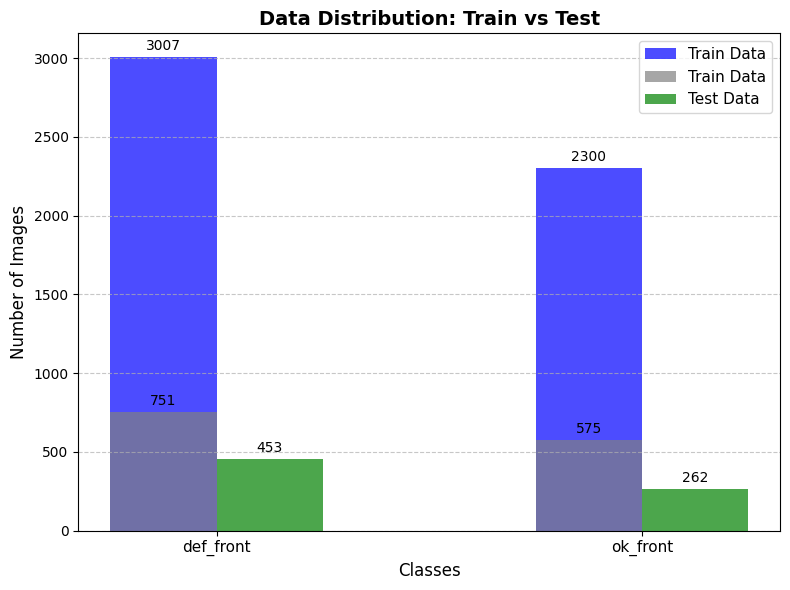

In [9]:
#bar plotting
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.25
x_indices = np.arange(len(labels))

train_bars = ax.bar(x_indices - bar_width / 2, x_train, bar_width, label='Train Data', color = 'blue', alpha=0.7)
Valid_bars = ax.bar(x_indices - bar_width / 2, x_valid, bar_width, label='Train Data', color = 'gray', alpha=0.7)
test_bars = ax.bar(x_indices + bar_width / 2, x_test, bar_width, label='Test Data', color = 'green', alpha=0.7)


# Annotate bars with counts
for bars in [train_bars, Valid_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), 
                    textcoords="offset points", 
                    ha='center', 
                    fontsize=10, 
                    color='black')

# Labels and title
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Data Distribution: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x_indices)
ax.set_xticklabels(labels, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.show()

Imbalances :
1) Data level approaches
a) Oversampling the Minority Class - SMOTE, Random oversamlping the minotiy (duplication)
b) Undersamping majority class (Random,Cluster based)
c) Data augmentation (flip, rotation etc which we have done before in the previous steps), Text augmentation : replcaing similarities

2)Algorithm based approach
a) Class weights - adding higher weights to minority class in loss function , which is added in the later section of this code
eg :  model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              class_weight={0: 1, 1: 5})  # Higher weight for minority class
b) cost sensitivity for decsion trree based alos for misclaffication of minority classes
c) Focal loss - adjust loss to foceus more on hard classfying data

We can use ROC AUC / PR AUC => imbalance report

Imbalances can be addressed with class weights

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weights)

Calculated Class Weights: {0: 0.8824409710675092, 1: 1.153695652173913}


Lets check the images for training in a batch

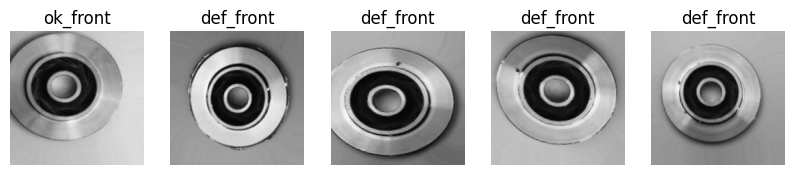

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels
images, labels = next(train_data)

# Get class labels
class_labels = list(train_data.class_indices.keys())

# Display 5 images from the batch
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])  # Get class name from one-hot encoding
    plt.axis('off')
plt.show()


CNN Model / Architecture

In [12]:
# Model layers
model = tf.keras.Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation= 'relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(2 ,activation='softmax')
])

# ✅ Fix: Explicitly build the model before Grad-CAM
model.build(input_shape=(None, 200, 200, 3))  # Ensures model is initialized

c:\Users\raoab\Anaconda3\envs\GENAI\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model compilation with Optimizer and loss function for error correction

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# from tensorflow.keras.utils import plot_model
# plot_model(
#     model,
#     show_shapes=True,
#     show_layer_names=True,
#     show_dtype=True,
#     show_trainable=True,
#     dpi=96 # Decrease dpi to reduce overall size
# )

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,916,706 (72.16 MB)

 Trainable params: 18,916,706 (72.16 MB)

 Non-trainable params: 0 (0.00 B)

Early stopping monitors validation loss and stops trining if no improvement observed in epochs (overfitting problem is ddressed and best weights are stored)

ReduceLROnPlateau monitors validation loss and reduces learning rate by fvtor of 0.5 if loss is const / pleteaus within 3 epochs...helps when model is stuck in local minimum (More like least increment in Mechanical simulations wwhen e check for convergence in abaqus)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

Callbacks => helps in overfitting and convergence , Class weights => we are using eights which was checked earlier to ddress class imbalance as during computation it might initialise randomly

In [17]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=3,
                    batch_size=32,
                    callbacks=callbacks,
                    class_weight=class_weights
                    )

Epoch 1/3


c:\Users\raoab\Anaconda3\envs\GENAI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.5000 - loss: 1.0524 - val_accuracy: 0.6124 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 2/3
166/166 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6282 - loss: 0.6305 - val_accuracy: 0.7805 - val_loss: 0.5105 - learning_rate: 0.0010
Epoch 3/3
166/166 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7600 - loss: 0.4961 - val_accuracy: 0.7979 - val_loss: 0.4255 - learning_rate: 0.0010


Plotting Accuracy

In [18]:
def plot_history(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.show()

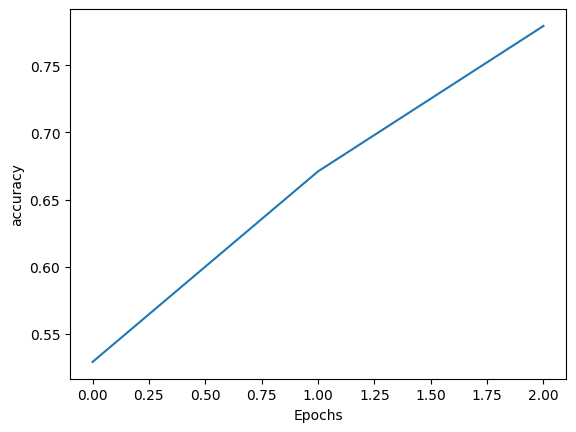

In [19]:
plot_history(history, 'accuracy')

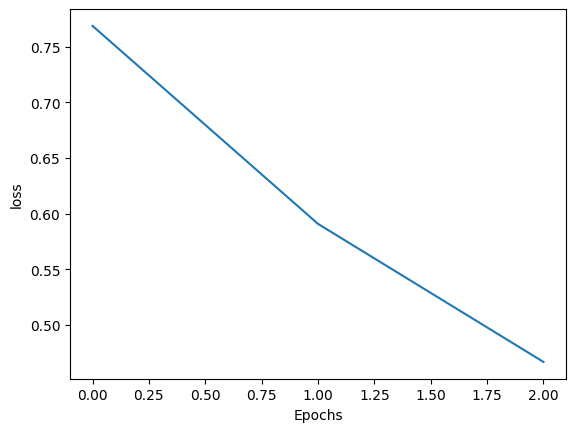

In [20]:
plot_history(history, 'loss')

In [21]:
result = model.evaluate(test_data)
print("Test loss, Test accuracy : ", result)

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.7049 - loss: 0.5912
Test loss, Test accuracy :  [0.48682084679603577, 0.7678321599960327]


**Model Evaluation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


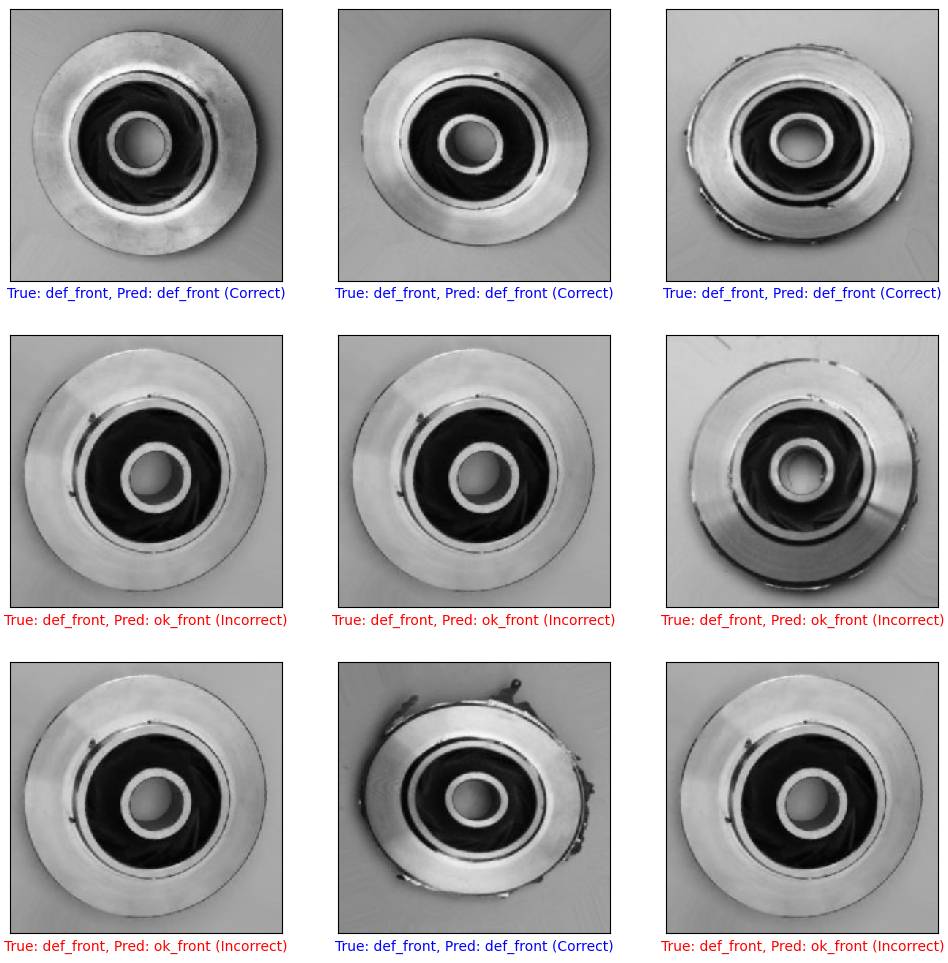

In [22]:
images, labels = next(test_data)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model.predict(images)


class_names=list(test_data.class_indices.keys())


plt.figure(figsize=(12,12))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

In [23]:
# Predict probabilities for the entire test dataset
y_pred_prob = model.predict(test_data)  # Shape: (715, 2)

# Get class indices with highest probability
y_pred = np.argmax(y_pred_prob, axis=1)  # Shape: (715,)

print(y_pred_prob.shape)  # Should be (715, 2)
print(y_pred.shape)  # Should be (715,)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step
(715, 2)
(715,)


In [24]:
y_actual = test_data.classes

In [25]:
y_actual.shape

(715,)

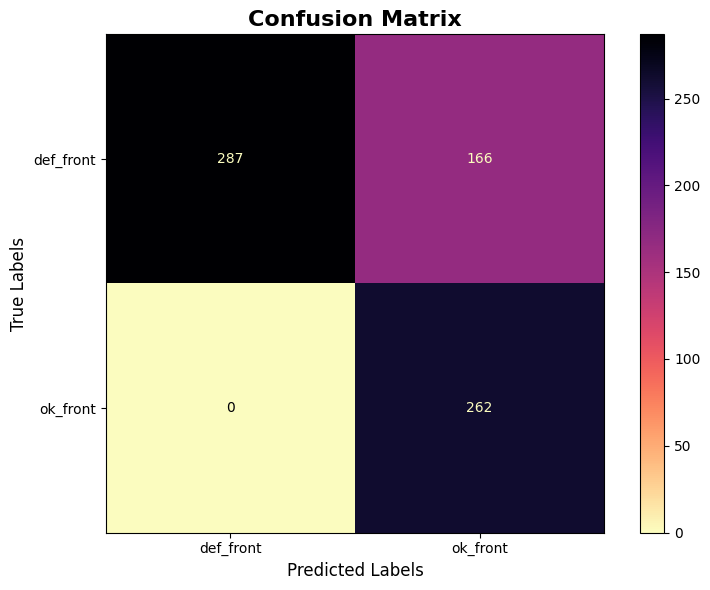


Classification Report:
              precision    recall  f1-score   support

   def_front     1.0000    0.6336    0.7757       453
    ok_front     0.6121    1.0000    0.7594       262

    accuracy                         0.7678       715
   macro avg     0.8061    0.8168    0.7675       715
weighted avg     0.8579    0.7678    0.7697       715



In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(test_data.class_indices.keys()))
disp.plot(cmap='magma_r', colorbar=True, ax=plt.gca())
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
report = classification_report(y_actual, y_pred, target_names=list(test_data.class_indices.keys()), digits=4)
print(report)

Lets save the weights for deployment

In [27]:
model.save('C://Explore/ML_AI/Projects/DL_projects/Metal_defect_classification/Dataset_disc_defects/casting_data/CNN_model.h5',include_optimizer=True)

In [28]:
model.save('CNN_model.h5')

In [29]:
print([layer.name for layer in model.layers])

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dropout', 'dense_1']


https://www.kaggle.com/code/rftexas/implementing-gradcam-with-keras-for-error-analysis/notebook?scriptVersionId=34164222

https://keras.io/examples/vision/grad_cam/

Currently facing errors in GRADCAM which could be used to locate cracks